In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from config.settings import settings
from scipy.stats import pearsonr

In [2]:
DATASETS_BASE = settings.MODULES_TO_DATASETS_PATH

In [3]:
df1_4 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_AIR_F1_4, low_memory=False)

In [4]:
df1_4.info

<bound method DataFrame.info of            countryName  EPRTRSectorCode   
0              Austria              4.0  \
1              Austria              9.0   
2              Austria              6.0   
3              Austria              6.0   
4              Austria              3.0   
...                ...              ...   
324550  United Kingdom              8.0   
324551  United Kingdom              5.0   
324552  United Kingdom              5.0   
324553  United Kingdom              7.0   
324554  United Kingdom              7.0   

                                          eprtrSectorName   
0                                       Chemical industry  \
1                                        Other activities   
2                Paper and wood production and processing   
3                Paper and wood production and processing   
4                                        Mineral industry   
...                                                   ...   
324550  Animal and veget

In [5]:
group_by_sector_pollutant = df1_4.groupby(["eprtrSectorName", "pollutant"])["emissions"].quantile(q=[0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 0.99]).reset_index()
group_by_sector_pollutant = group_by_sector_pollutant.rename(columns={"level_2": "Quantile", "emissions": "EmissionsQuantile"})

print(group_by_sector_pollutant.columns)
print(len(group_by_sector_pollutant))
print(group_by_sector_pollutant.head())

def get_category(sector: str, pollutant: str, emission: float, return_col: str, last_elem: int = -1) -> float:
    subset = group_by_sector_pollutant[
        (group_by_sector_pollutant.eprtrSectorName == sector) &
        (group_by_sector_pollutant.pollutant == pollutant) &
        (group_by_sector_pollutant.EmissionsQuantile < emission)
    ][return_col]

    return subset.iloc[last_elem] if len(subset) > 0 else 0.0

df1_4["Quantile"] = df1_4.apply(
    lambda x: get_category(
        x["eprtrSectorName"],
        x["pollutant"],
        x["emissions"],
        "Quantile"
    ),
    axis=1
)

Index(['eprtrSectorName', 'pollutant', 'Quantile', 'EmissionsQuantile'], dtype='object')
3184
                                     eprtrSectorName      pollutant  Quantile   
0  Animal and vegetable products from the food an...  Ammonia (NH3)     0.125  \
1  Animal and vegetable products from the food an...  Ammonia (NH3)     0.250   
2  Animal and vegetable products from the food an...  Ammonia (NH3)     0.375   
3  Animal and vegetable products from the food an...  Ammonia (NH3)     0.500   
4  Animal and vegetable products from the food an...  Ammonia (NH3)     0.625   

   EmissionsQuantile  
0            11800.0  
1            14200.0  
2            17700.0  
3            22500.0  
4            32950.0  


In [6]:
df1_4.head()

,countryName,EPRTRSectorCode,eprtrSectorName,EPRTRAnnexIMainActivityCode,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,facilityNameConfidentialityReason,Longitude,Latitude,addressConfidentialityReason,City,targetRelease,pollutant,emissions,reportingYear,releasesConfidentialityReason,Quantile
0,Austria,4.0,Chemical industry,4(d),Chemical installations for the production on a...,AT.CAED/9008390392737.FACILITY,Nufarm GmbH & CO KG,NaN,14.336056,48.290943,NaN,Linz,AIR,"1,2-dichloroethane (DCE-1,2)",3300.0,2007,NaN,0.250
1,Austria,9.0,Other activities,9(c),Installations for the surface treatment of sub...,AT.CAED/9008390396414.FACILITY,MAGNA STEYR Fahrzeugtechnik AG&Co KG,NaN,15.477778,47.019170,NaN,"Graz,07.Bez.:Liebenau",AIR,Non-methane volatile organic compounds (NMVOC),170000.0,2007,NaN,0.250
2,Austria,6.0,Paper and wood production and processing,6(b),Industrial plants for the production of paper ...,AT.CAED/9008390397176.FACILITY,Fritz EGGER GmbH & Co. OG,NaN,15.691833,48.259556,NaN,Unterradlberg,AIR,Carbon dioxide (CO2),228000000.0,2007,NaN,0.375
3,Austria,6.0,Paper and wood production and processing,6(b),Industrial plants for the production of paper ...,AT.CAED/9008390397176.FACILITY,Fritz EGGER GmbH & Co. OG,NaN,15.691833,48.259556,NaN,Unterradlberg,AIR,Nitrogen oxides (NOX),311000.0,2007,NaN,0.500
4,Austria,3.0,Mineral industry,3(c),Installations for the production of cement cli...,AT.CAED/9008390397220.FACILITY,voestalpine Stahl GmbH,NaN,14.159778,47.807083,NaN,Klaus an der Pyhrnbahn,AIR,Carbon dioxide (CO2),329000000.0,2007,NaN,0.375


In [7]:
df1_4.Quantile.unique()

array([0.25 , 0.375, 0.5  , 0.125, 0.875, 0.625, 0.75 , 0.   , 0.99 ])

In [8]:
def map_quantile_to_grade(quantile):
    grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    # Assurez-vous que le quantile est dans l'intervalle [0, 1]
    if 0 <= quantile <= 1:
        # Déterminer l'indice pour la lettre correspondante
        index = int(quantile * 8) - 1 if quantile > 0 else 0
        return grades[index]
    return 'Unknown'

In [9]:
df1_4['Grade'] = df1_4['Quantile'].apply(map_quantile_to_grade)

In [10]:
df1_4[['eprtrSectorName', 'pollutant', 'emissions', 'Quantile', 'Grade']].head()

,eprtrSectorName,pollutant,emissions,Quantile,Grade
0,Chemical industry,"1,2-dichloroethane (DCE-1,2)",3300.0,0.250,B
1,Other activities,Non-methane volatile organic compounds (NMVOC),170000.0,0.250,B
2,Paper and wood production and processing,Carbon dioxide (CO2),228000000.0,0.375,C
3,Paper and wood production and processing,Nitrogen oxides (NOX),311000.0,0.500,D
4,Mineral industry,Carbon dioxide (CO2),329000000.0,0.375,C


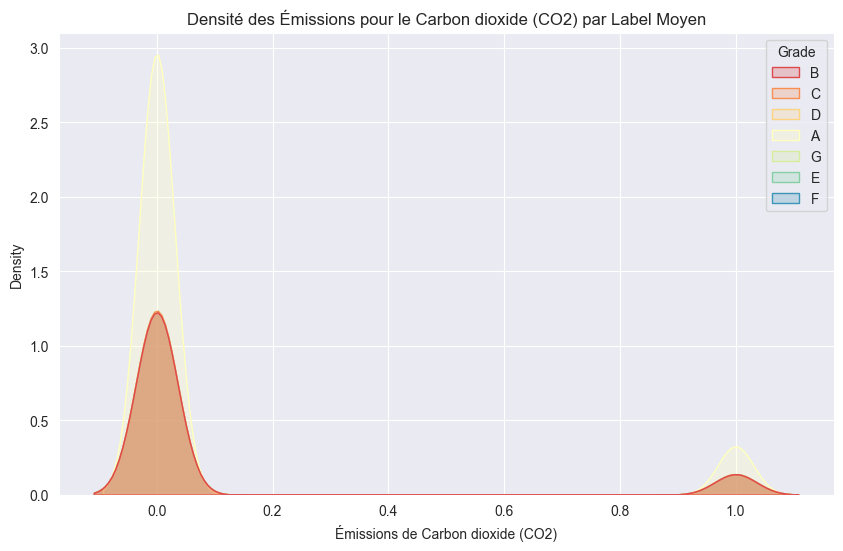

In [11]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x=df1_4.pollutant == 'Carbon dioxide (CO2)', hue='Grade', data=df1_4, palette='Spectral', fill=True)
plt.title('Densité des Émissions pour le Carbon dioxide (CO2) par Label Moyen')
plt.xlabel('Émissions de Carbon dioxide (CO2)')
plt.show()

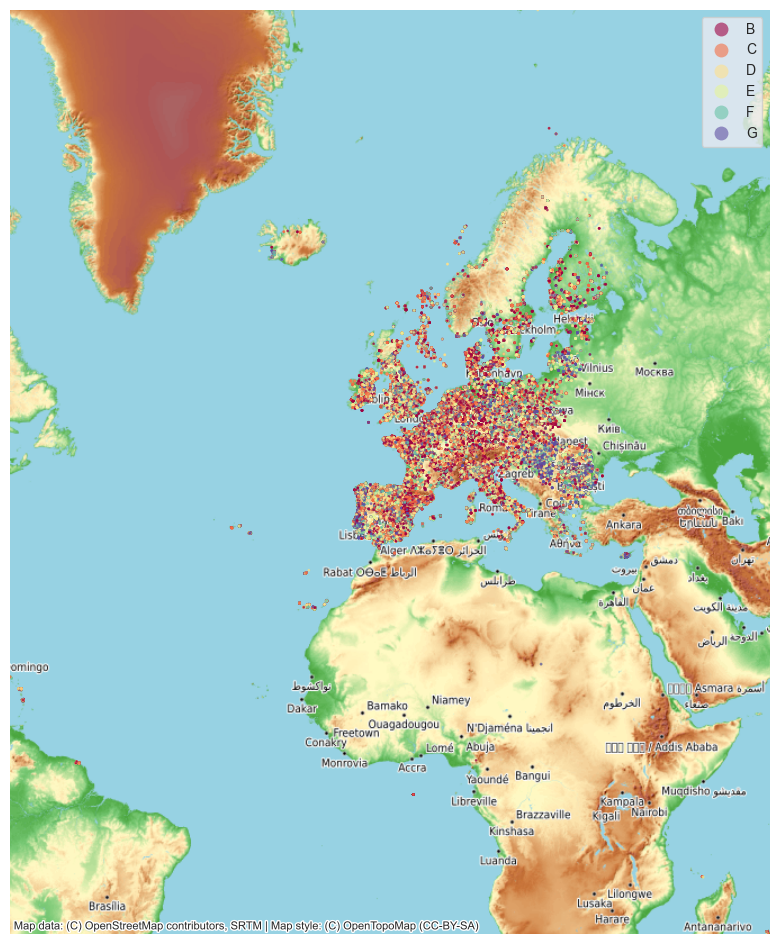

In [12]:
# pip install geopandas contextily

import geopandas as gpd
import contextily as ctx

# Créer un GeoDataFrame à partir de votre DataFrame
gdf = gpd.GeoDataFrame(df1_4, geometry=gpd.points_from_xy(df1_4.Longitude, df1_4.Latitude))

# Filtrer pour exclure les notes 'A'
gdf = gdf[gdf['Grade'] != 'A']

# Définir le système de coordonnées (CRS) pour les coordonnées géographiques
gdf.set_crs(epsg=4326, inplace=True)  # EPSG:4326 est le code pour WGS84

# Conversion au système de coordonnées utilisé par contextily
gdf = gdf.to_crs(epsg=3857)  # EPSG:3857 est le système de coordonnées pour les tuiles web

# Tracer la carte
fig, ax = plt.subplots(figsize=(18, 12))
gdf.plot(ax=ax, column='Grade', categorical=True, legend=True, markersize=1, cmap='Spectral', alpha=0.6)

# Ajouter une carte de base
ctx.add_basemap(ax, source=ctx.providers.OpenTopoMap)

# Ajuster les limites et le format
ax.set_axis_off()
ax.set_xlim(gdf.total_bounds[[0, 2]])
ax.set_ylim(gdf.total_bounds[[1, 3]])
plt.show()

Transformation du dataset en vue de classification

In [13]:
# Création d'un dataset avec une ligne par entreprise et par an, avec comme feature les différents polluants

# Regroupement par entreprise et année, en utilisant le mode pour les grades
df_agg_per_FacilityInspireID_per_year = df1_4.groupby(['FacilityInspireID', 'reportingYear'])['Grade'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).reset_index()

In [14]:
df_agg_per_FacilityInspireID_per_year.Grade.value_counts()

Grade
A    59212
B    24109
C    22261
D    20481
E    19233
F    18012
G    16181
Name: count, dtype: int64

In [20]:
# Préparation des données
# X sera votre ensemble de features (variables explicatives)
# y sera votre variable cible (les grades dans ce cas)

# Exclure la colonne problématique
X = df_agg_per_FacilityInspireID_per_year.drop(columns=['Grade', 'FacilityInspireID'])
y = df_agg_per_FacilityInspireID_per_year['Grade']

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Définition des modèles et des paramètres pour GridSearch
model_params = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 50, 100]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [1, 10, 100],
            'kernel': ['rbf', 'linear']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    }
}

# Exécution de GridSearch pour chaque modèle
scores = []
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

df_model_scores = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
print(df_model_scores)

              model  best_score                                   best_params
0      RandomForest    0.329892                          {'n_estimators': 10}
1               SVM    0.329892                     {'C': 1, 'kernel': 'rbf'}
2  GradientBoosting    0.329892  {'learning_rate': 0.01, 'n_estimators': 100}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Réduction de la dimensionnalité pour permettre l'accélération du processus
pca = PCA(n_components=0.95)

# Définition des modèles et des hyper-paramètres pour RandomizedSearchCV avec le format adapté pour un pipeline
model_params = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'clf__n_estimators': [10, 50, 100],
            'clf__max_depth': [5, 10, None]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['rbf', 'linear']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'clf__n_estimators': [50, 100],
            'clf__learning_rate': [0.01, 0.1]
        }
    }
}

# Exécution de RandomizedSearchCV pour chaque modèle
scores = []
for model_name, mp in model_params.items():
    model_pipeline = Pipeline([('pca', pca), ('clf', mp['model'])])
    clf = RandomizedSearchCV(model_pipeline, mp['params'], cv=3, n_jobs=-1, n_iter=10, verbose=2)
    print(f"Entraînement {model_name}")
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

df_model_scores = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
print(df_model_scores)

Entraînement RandomForest
Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\Sysiph'Eros\Desktop\Environmental_Impact\venv\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Entraînement SVM
Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\Sysiph'Eros\Desktop\Environmental_Impact\venv\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import joblib

# Sélection des meilleurs params du meilleur modèle, ici RandomForest
best_params = df_model_scores.iloc[df_model_scores['best_score'].idxmax()]['best_params']

# Création du modèle avec les meilleurs paramètres
best_model = RandomForestClassifier(**best_params)

# Validation croisée stratifiée
skf = StratifiedKFold(n_splits=5)
scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_model.fit(X_train, y_train)
    predictions = best_model.predict(X_test)
    score = accuracy_score(y_test, predictions)
    scores.append(score)
    print(f"Score pour le fold : {score}")

print(f"Moyenne des scores de validation croisée : {sum(scores)/len(scores)}")

# Enregistrement du modèle
joblib.dump(best_model, 'best_random_forest_model.pkl')

# Chargement du modèle (pour utilisation ultérieure)
loaded_model = joblib.load('best_random_forest_model.pkl')

In [5]:
df_pivoted = df1_4.pivot_table(index=['FacilityInspireID', 'reportingYear'],
                                columns='pollutant',
                                values='emissions',
                                aggfunc='sum').reset_index()

df_pivoted.reset_index(inplace=True)
df_pivoted.iloc[:, 3:] = df_pivoted.iloc[:, 3:].fillna(0)

In [6]:
df_unique = df1_4.drop_duplicates(subset=['FacilityInspireID', 'reportingYear']).drop(columns=['pollutant', 'emissions'])

In [7]:
df_final = pd.merge(df_unique, df_pivoted, on=['FacilityInspireID', 'reportingYear'], how='left')

# Dataset transformé
df_final = df_final.drop(columns=['index'])

In [8]:
df_final.info

<bound method DataFrame.info of            countryName  EPRTRSectorCode   
0              Austria              4.0  \
1              Austria              9.0   
2              Austria              6.0   
3              Austria              3.0   
4              Austria              9.0   
...                ...              ...   
179484  United Kingdom              1.0   
179485  United Kingdom              8.0   
179486  United Kingdom              5.0   
179487  United Kingdom              7.0   
179488  United Kingdom              7.0   

                                          eprtrSectorName   
0                                       Chemical industry  \
1                                        Other activities   
2                Paper and wood production and processing   
3                                        Mineral industry   
4                                        Other activities   
...                                                   ...   
179484                  

In [9]:
df_final.columns

Index(['countryName', 'EPRTRSectorCode', 'eprtrSectorName',
       'EPRTRAnnexIMainActivityCode', 'EPRTRAnnexIMainActivityLabel',
       'FacilityInspireID', 'facilityName',
       'facilityNameConfidentialityReason', 'Longitude', 'Latitude',
       'addressConfidentialityReason', 'City', 'targetRelease',
       'reportingYear', 'releasesConfidentialityReason',
       '1,1,1-trichloroethane (TCE-1,1,1)',
       '1,1,2,2-tetrachloroethane (TETRACHLOROETHANE-1,1,2,2)',
       '1,2,3,4,5,6-hexachlorocyclohexane (HCH)',
       '1,2-dichloroethane (DCE-1,2)', 'Aldrin', 'Ammonia (NH3)', 'Anthracene',
       'Arsenic and compounds (as As)', 'Asbestos', 'Benzene',
       'Benzo(g,h,i)perylene', 'Brominated diphenylethers (PBDE)',
       'CONFIDENTIAL', 'Cadmium and compounds (as Cd)', 'Carbon dioxide (CO2)',
       'Carbon dioxide (CO2) excluding biomass', 'Carbon monoxide (CO)',
       'Chlordecone', 'Chlorides (as total Cl)',
       'Chlorine and inorganic compounds (as HCl)',
       'Chloro

In [10]:
correlation_matrix = df_final.iloc[:, 15:].corr(method='pearson')

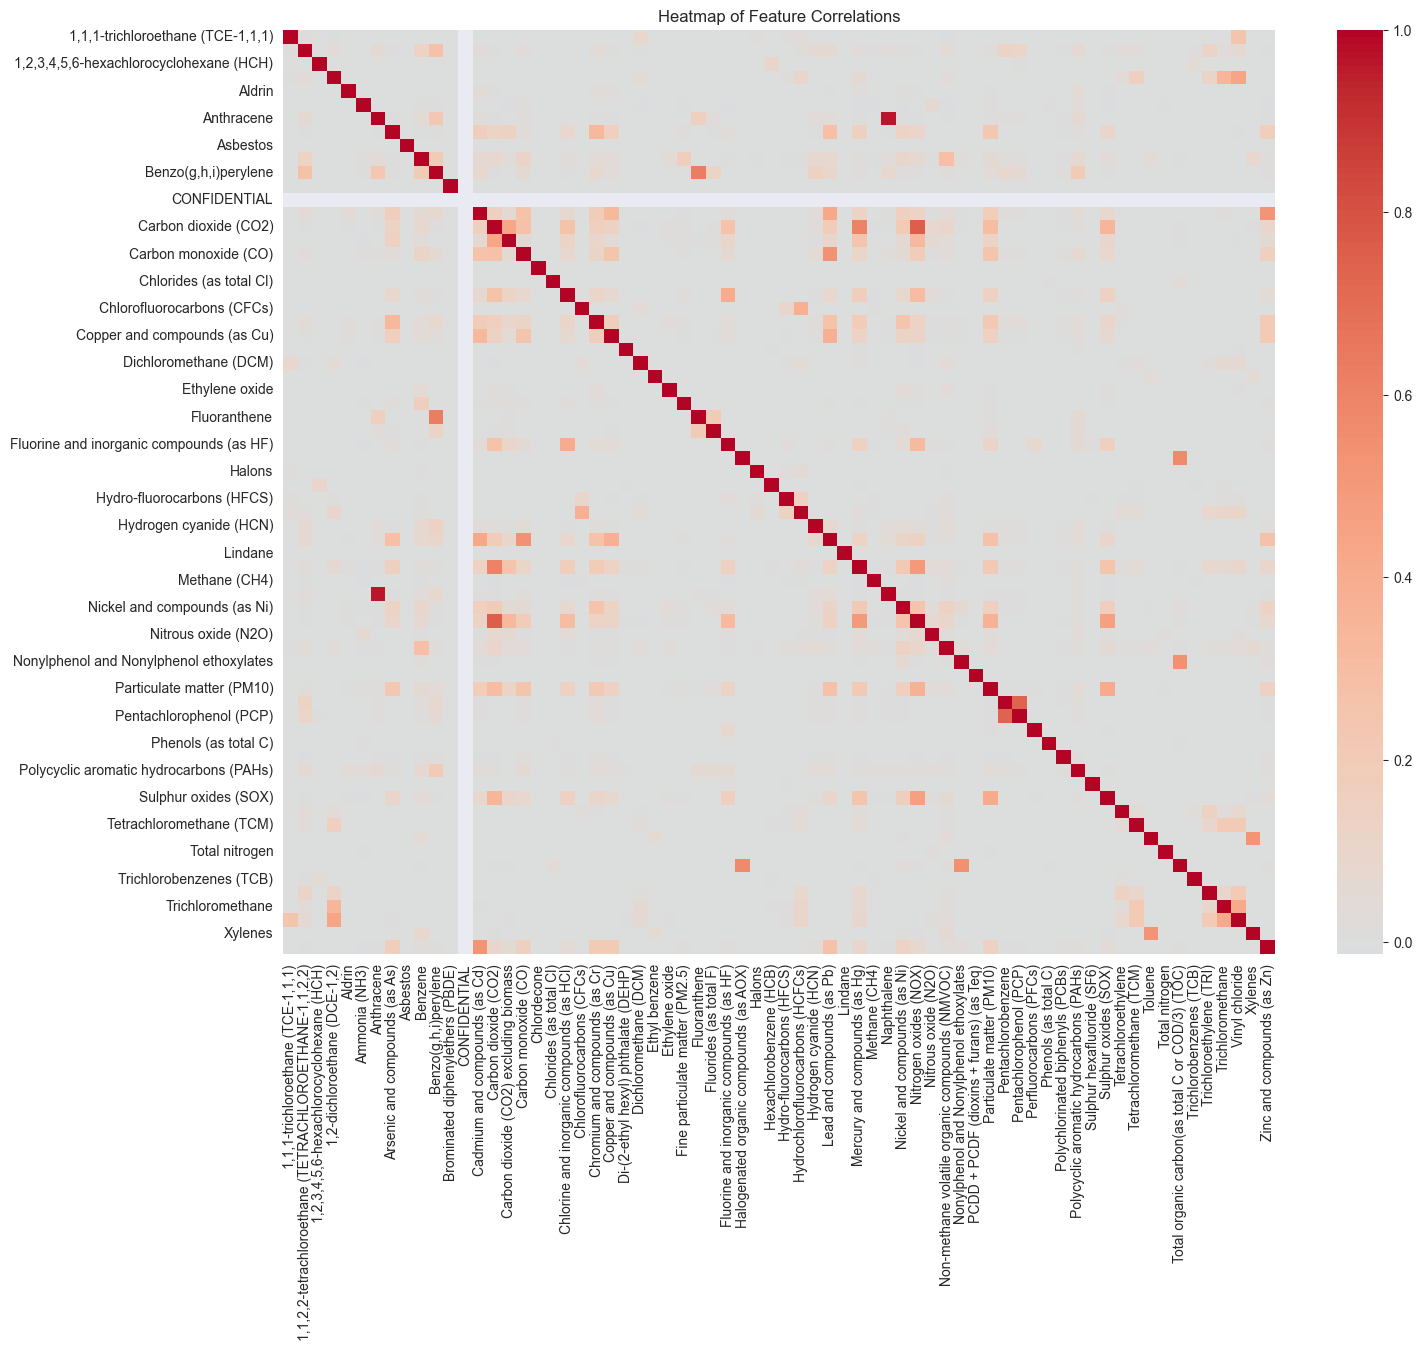

In [11]:
plt.figure(figsize=(16, 12))

heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)

plt.title('Heatmap of Feature Correlations')

plt.show()

In [12]:
threshold = 0.75  # This is an arbitrary threshold

high_correlations = np.where(np.abs(correlation_matrix) > threshold)

high_correlations = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                     for x, y in zip(*high_correlations)
                     if x != y and x < y]

In [13]:
for pair in high_correlations:
    corr_value, p_value = pearsonr(df_final[pair[0]], df_final[pair[1]])
    print(f"Correlation between {pair[0]} and {pair[1]}: {corr_value}, P-value: {p_value}")

Correlation between Anthracene and Naphthalene: 0.9613208385860071, P-value: 0.0
Correlation between Carbon dioxide (CO2) and Nitrogen oxides (NOX): 0.7564119404282662, P-value: 0.0
